In [125]:
import pandas as pd 
import urllib
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import itertools
%matplotlib inline

In [2]:
# download annotated comments and annotations

ANNOTATED_COMMENTS_URL = 'https://ndownloader.figshare.com/files/7554634' 
ANNOTATIONS_URL = 'https://ndownloader.figshare.com/files/7554637' 

def download_file(url, fname):
    urllib.request.urlretrieve(url, fname)

                
download_file(ANNOTATED_COMMENTS_URL, 'attack_annotated_comments.tsv')
download_file(ANNOTATIONS_URL, 'attack_annotations.tsv')

In [3]:
comments = pd.read_csv('attack_annotated_comments.tsv', sep = '\t', index_col = 0)
annotations = pd.read_csv('attack_annotations.tsv',  sep = '\t')

In [4]:
print(comments)

                                                     comment  year  logged_in  \
rev_id                                                                          
37675      `-NEWLINE_TOKENThis is not ``creative``.  Thos...  2002      False   
44816      `NEWLINE_TOKENNEWLINE_TOKEN:: the term ``stand...  2002      False   
49851      NEWLINE_TOKENNEWLINE_TOKENTrue or false, the s...  2002      False   
89320       Next, maybe you could work on being less cond...  2002       True   
93890                   This page will need disambiguation.   2002       True   
...                                                      ...   ...        ...   
699848324  `NEWLINE_TOKENNEWLINE_TOKENNEWLINE_TOKENThese ...  2016       True   
699851288  NEWLINE_TOKENNEWLINE_TOKENThe Institute for Hi...  2016       True   
699857133  NEWLINE_TOKEN:The way you're trying to describ...  2016       True   
699891012  NEWLINE_TOKENNEWLINE_TOKEN== Warning ==NEWLINE...  2016       True   
699897151  Alternate option=

## Data Cleaning

#### Here we removing all unnecessay symbols, puctuations and extra white space

In [5]:
# remove newline and tab tokens
comments['comment'] = comments['comment'].apply(lambda x: x.replace("NEWLINE_TOKEN", " "))
comments['comment'] = comments['comment'].apply(lambda x: x.replace("TAB_TOKEN", " "))
comments['comment'] = comments['comment'].apply(lambda x: x.replace("TAB_TOKEN", " "))

In [6]:
print(comments)

                                                     comment  year  logged_in  \
rev_id                                                                          
37675      `- This is not ``creative``.  Those are the di...  2002      False   
44816      `  :: the term ``standard model`` is itself le...  2002      False   
49851        True or false, the situation as of March 200...  2002      False   
89320       Next, maybe you could work on being less cond...  2002       True   
93890                   This page will need disambiguation.   2002       True   
...                                                      ...   ...        ...   
699848324  `   These sources don't exactly exude a sense ...  2016       True   
699851288    The Institute for Historical Review is a pee...  2016       True   
699857133   :The way you're trying to describe it in this...  2016       True   
699891012    == Warning ==  There is clearly a protection...  2016       True   
699897151  Alternate option=

In [55]:
# removing spcial symbols
comments['comment'] = comments['comment'].apply(lambda x: x.replace("==", " "))
comments['comment'] = comments['comment'].apply(lambda x: x.replace("`", " "))
comments['comment'] = comments['comment'].apply(lambda x: x.replace("::", " "))
comments['comment'] = comments['comment'].apply(lambda x: x.replace("-", " "))
comments['comment'] = comments['comment'].apply(lambda x: x.replace(":", " "))
comments['comment'] = comments['comment'].apply(lambda x: x.replace(",", " "))
comments['comment'] = comments['comment'].apply(lambda x: x.replace("=", " "))


In [56]:
#drop NaN
df1 = comments.dropna()

In [57]:
df1

,comment,year,logged_in,ns,sample,split
rev_id,,,,,,
37675,This is not creative . Those are the di...,2002,False,article,random,train
44816,the term standard model is itself les...,2002,False,article,random,train
49851,True or false the situation as of March 200...,2002,False,article,random,train
89320,Next maybe you could work on being less cond...,2002,True,article,random,dev
93890,This page will need disambiguation.,2002,True,article,random,train
...,...,...,...,...,...,...
699848324,These sources don't exactly exude a sense ...,2016,True,article,blocked,train
699851288,The Institute for Historical Review is a pee...,2016,True,article,blocked,test
699857133,The way you're trying to describe it in this...,2016,True,article,blocked,train


In [58]:
comments.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115864 entries, 37675 to 699897151
Data columns (total 6 columns):
comment      115864 non-null object
year         115864 non-null int64
logged_in    115864 non-null bool
ns           115864 non-null object
sample       115864 non-null object
split        115864 non-null object
dtypes: bool(1), int64(1), object(4)
memory usage: 3.6+ MB


In [59]:
print(annotations)

            rev_id  worker_id  quoting_attack  recipient_attack  \
0            37675       1362             0.0               0.0   
1            37675       2408             0.0               0.0   
2            37675       1493             0.0               0.0   
3            37675       1439             0.0               0.0   
4            37675        170             0.0               0.0   
...            ...        ...             ...               ...   
1365212  699897151        628             0.0               0.0   
1365213  699897151         15             0.0               0.0   
1365214  699897151         57             0.0               0.0   
1365215  699897151       1815             0.0               0.0   
1365216  699897151        472             0.0               0.0   

         third_party_attack  other_attack  attack  
0                       0.0           0.0     0.0  
1                       0.0           0.0     0.0  
2                       0.0           0

In [60]:
df2 = annotations.dropna()

In [61]:
df2

,rev_id,worker_id,quoting_attack,recipient_attack,third_party_attack,other_attack,attack
0,37675,1362,0.0,0.0,0.0,0.0,0.0
1,37675,2408,0.0,0.0,0.0,0.0,0.0
2,37675,1493,0.0,0.0,0.0,0.0,0.0
3,37675,1439,0.0,0.0,0.0,0.0,0.0
4,37675,170,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
1365212,699897151,628,0.0,0.0,0.0,0.0,0.0
1365213,699897151,15,0.0,0.0,0.0,0.0,0.0
1365214,699897151,57,0.0,0.0,0.0,0.0,0.0
1365215,699897151,1815,0.0,0.0,0.0,0.0,0.0


In [62]:
annotations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1365217 entries, 0 to 1365216
Data columns (total 7 columns):
rev_id                1365217 non-null int64
worker_id             1365217 non-null int64
quoting_attack        1365217 non-null float64
recipient_attack      1365217 non-null float64
third_party_attack    1365217 non-null float64
other_attack          1365217 non-null float64
attack                1365217 non-null float64
dtypes: float64(5), int64(2)
memory usage: 72.9 MB


In [63]:
#change all in small letter
df1.comment = df1.comment.apply(lambda x: x.lower())

In [64]:
df1

,comment,year,logged_in,ns,sample,split
rev_id,,,,,,
37675,this is not creative . those are the di...,2002,False,article,random,train
44816,the term standard model is itself les...,2002,False,article,random,train
49851,true or false the situation as of march 200...,2002,False,article,random,train
89320,next maybe you could work on being less cond...,2002,True,article,random,dev
93890,this page will need disambiguation.,2002,True,article,random,train
...,...,...,...,...,...,...
699848324,these sources don't exactly exude a sense ...,2016,True,article,blocked,train
699851288,the institute for historical review is a pee...,2016,True,article,blocked,test
699857133,the way you're trying to describe it in this...,2016,True,article,blocked,train


In [65]:
#removing puctuations
import string
df1.comment = df1.comment.apply(lambda x: x.translate(string.punctuation))

In [66]:
df1

,comment,year,logged_in,ns,sample,split
rev_id,,,,,,
37675,this is not creative . those are the di...,2002,False,article,random,train
44816,the term standard model is itself les...,2002,False,article,random,train
49851,true or false the situation as of march 200...,2002,False,article,random,train
89320,next maybe you could work on being less cond...,2002,True,article,random,dev
93890,this page will need disambiguation.,2002,True,article,random,train
...,...,...,...,...,...,...
699848324,these sources don't exactly exude a sense ...,2016,True,article,blocked,train
699851288,the institute for historical review is a pee...,2016,True,article,blocked,test
699857133,the way you're trying to describe it in this...,2016,True,article,blocked,train


### Merging data df1 ad df2

In [70]:
#join data as per rev_id
combine_data = pd.merge(df1, df2, on='rev_id')

In [71]:
combine_data

,rev_id,comment,year,logged_in,ns,sample,split,worker_id,quoting_attack,recipient_attack,third_party_attack,other_attack,attack
0,37675,this is not creative . those are the di...,2002,False,article,random,train,1362,0.0,0.0,0.0,0.0,0.0
1,37675,this is not creative . those are the di...,2002,False,article,random,train,2408,0.0,0.0,0.0,0.0,0.0
2,37675,this is not creative . those are the di...,2002,False,article,random,train,1493,0.0,0.0,0.0,0.0,0.0
3,37675,this is not creative . those are the di...,2002,False,article,random,train,1439,0.0,0.0,0.0,0.0,0.0
4,37675,this is not creative . those are the di...,2002,False,article,random,train,170,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1365212,699897151,alternate option is there perhaps enough new...,2016,True,article,blocked,train,628,0.0,0.0,0.0,0.0,0.0
1365213,699897151,alternate option is there perhaps enough new...,2016,True,article,blocked,train,15,0.0,0.0,0.0,0.0,0.0
1365214,699897151,alternate option is there perhaps enough new...,2016,True,article,blocked,train,57,0.0,0.0,0.0,0.0,0.0
1365215,699897151,alternate option is there perhaps enough new...,2016,True,article,blocked,train,1815,0.0,0.0,0.0,0.0,0.0


In [81]:
combine_data.attack.unique()

array([0., 1.])

In [102]:
#selectin 100 records due to memory issue or error
Data = combine_data[:100]

In [103]:
#Removing unnecessay column like split
Data_for_prediction = Data.drop(['split'],axis=1)
Data_for_prediction

,rev_id,comment,year,logged_in,ns,sample,worker_id,quoting_attack,recipient_attack,third_party_attack,other_attack,attack
0,37675,this is not creative . those are the di...,2002,False,article,random,1362,0.0,0.0,0.0,0.0,0.0
1,37675,this is not creative . those are the di...,2002,False,article,random,2408,0.0,0.0,0.0,0.0,0.0
2,37675,this is not creative . those are the di...,2002,False,article,random,1493,0.0,0.0,0.0,0.0,0.0
3,37675,this is not creative . those are the di...,2002,False,article,random,1439,0.0,0.0,0.0,0.0,0.0
4,37675,this is not creative . those are the di...,2002,False,article,random,170,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
95,128532,someone wrote more recognizable perhaps is...,2002,True,article,random,2671,0.0,0.0,0.0,0.0,0.0
96,133562,correct. full biographical details will put...,2002,True,article,random,3709,0.0,0.0,0.0,0.0,0.0
97,133562,correct. full biographical details will put...,2002,True,article,random,3710,0.0,0.0,0.0,0.0,0.0
98,133562,correct. full biographical details will put...,2002,True,article,random,706,0.0,0.0,0.0,0.0,0.0


### Here we add nagative comments for 0 overall attack and positive comments  for 1 overall attack


         Negative comment(attack):    = 0
         Positive comment(attack):    = 1


### Train/Test Split over a "`attack`" column which used for view analysis

#### Build a MLP classifier to identify whether the review has positive or negative attack. MLP Classifier model 
#### will use the words `comment`( column) and ratings (`attack`) from the training data to develop a model to 
#### predict target (`attack`).

In [104]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

x_train, x_test, y_train, y_test = train_test_split(Data_for_prediction.comment, Data_for_prediction.attack, random_state=0)

In [105]:
cv = CountVectorizer()
X_traincv = cv.fit_transform(x_train)  
X_testcv = cv.transform(x_test)

---
# 'ML Deep neural networks'
#### Now we will  fit train and test data into the MLP Classifer to predict the score
---

In [106]:
from sklearn.preprocessing import StandardScaler
# Training the model
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report,confusion_matrix

In [107]:
mlp = MLPClassifier()

In [108]:
X_traincv

<75x794 sparse matrix of type '<class 'numpy.int64'>'
	with 7391 stored elements in Compressed Sparse Row format>

In [110]:
mlp.fit(X_traincv,y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [111]:
# predict the target on the train dataset
pred_train = mlp.predict(X_traincv)
pred_train

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0.])

In [112]:
# Accuray Score on train dataset
accur_train = accuracy_score(y_train,pred_train)
print('accuracy_score on train dataset : ', accur_train)

accuracy_score on train dataset :  0.96


In [113]:
# predict the target on the train dataset
pred_test = mlp.predict(X_testcv)
pred_test

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0.])

In [115]:
# Accuray Score on train dataset
accur_test = accuracy_score(y_test,pred_test)
print('accuracy_score on train dataset : ', accur_test)

accuracy_score on train dataset :  0.96


In [116]:
#confusion matrix to find to mark predicted value
cnf = confusion_matrix(y_test,pred_test)
cnf

array([[24,  0],
       [ 1,  0]], dtype=int64)

# Result with score and accuracy
#### Below complete classfication record with f1 score with accuracy

In [117]:
print(classification_report(y_train,pred_train))

              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98        72
         1.0       0.00      0.00      0.00         3

    accuracy                           0.96        75
   macro avg       0.48      0.50      0.49        75
weighted avg       0.92      0.96      0.94        75



C:\Users\Admin\AppData\Local\Programs\Python\Python37-32\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [118]:
len(mlp.coefs_)

2

In [119]:
len(mlp.intercepts_[0])

100

In [120]:
#Number of tatal layers
mlp.n_layers_

3

In [121]:
#starting loss
print(mlp.loss_)

0.06819406840000793


## Data Exploration to show confusion matrix and predicted value.

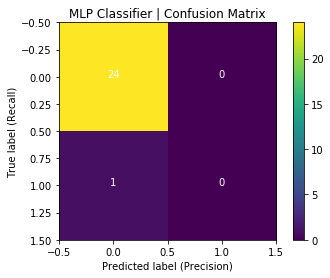

In [126]:
plt.imshow(cnf, interpolation='nearest')

for i, j in itertools.product(range(cnf.shape[0]), range(cnf.shape[1])):
    plt.text(j, i, cnf[i, j],
             horizontalalignment="center",
             color="white")

plt.ylabel('True label (Recall)')
plt.xlabel('Predicted label (Precision)')
plt.title('MLP Classifier | Confusion Matrix')
plt.colorbar();